In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
data_handler

NameError: name 'data_handler' is not defined

In [8]:
from config import settings
settings.path


AttributeError: 'Settings' object has no attribute 'PATH'

In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# Path to data
root_path = Path().cwd().parent
data_path = root_path / 'data' / 'processed2'
# List of files
import sys
EPS = sys.float_info.epsilon

In [10]:
anomaly = np.load(data_path / 'anomaly.npy')


In [11]:
len(anomaly)

52000

In [12]:
freq = np.load(data_path / 'freq.npy')
PSDs = np.load(data_path / 'psds.npy')
system_name = np.load(data_path / 'labels.npy')
states = np.load(data_path / 'states.npy')
anomaly = np.load(data_path / 'anomaly.npy')
latent = np.load(data_path / 'latent.npy')

In [13]:
mean_RMS = (1/2*np.pi)*np.sum(PSDs,axis=-1).mean(axis=-1)

In [14]:
from scipy import signal

n_sample = int(30/0.0025)



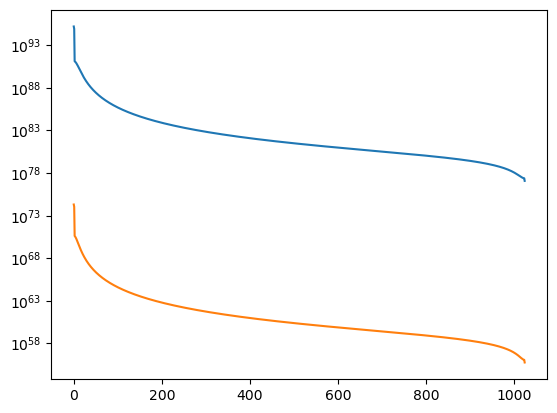

In [15]:
plt.plot(PSDs[0])
plt.plot(PSDs[1])
plt.yscale('log')

In [35]:
SNR = 12
noise = np.random.normal(0,SNR*mean_RMS/n_sample,(n_sample,))

noise_freq = signal.welch(noise,1/0.0025,nperseg=1024,scaling='spectrum')[1]
PSDs_noisy = PSDs + noise_freq


/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1893: RuntimeWarning: overflow encountered in multiply
  result = np.conjugate(result) * result
/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1893: RuntimeWarning: invalid value encountered in multiply
  result = np.conjugate(result) * result
/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1895: RuntimeWarning: invalid value encountered in multiply
  result *= scale


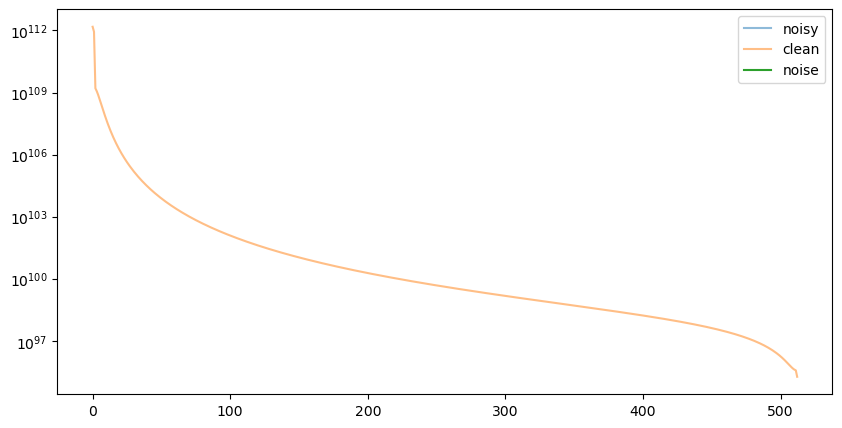

In [36]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(PSDs_noisy[0],label='noisy',alpha=0.5)
ax.plot(PSDs[0],label='clean',alpha=0.5)
ax.plot(noise_freq[0],label='noise',alpha=1)
ax.set_yscale('log')
ax.legend()

In [693]:
PSDs =  PSDs_noisy[:,0:250]

In [694]:
np.unique(anomaly)

array([0.  , 0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13])

In [695]:
np.sum(system_name=='system_0')

2600

In [696]:
idx_healty = np.where((system_name=='system_0')&(states=='healthy'))[0]

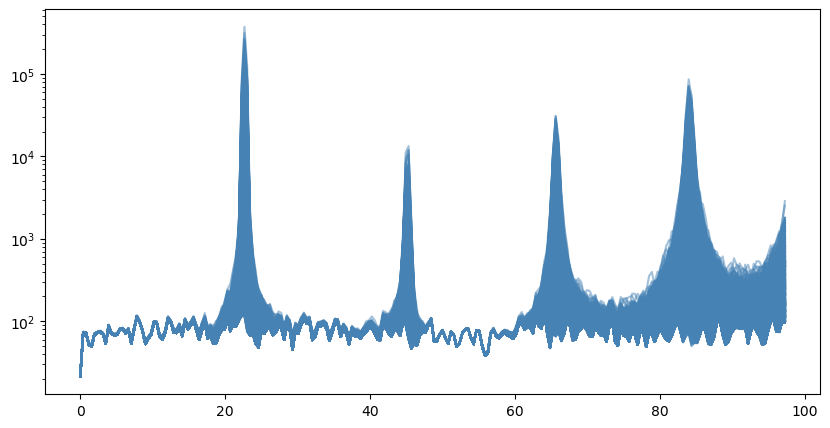

In [697]:
plt.figure(figsize=(10,5))
plt.plot(freq[:250],PSDs[idx_healty].T,label='healthy',color='steelblue',alpha=0.5)
plt.yscale('log')


ValueError: x and y must have same first dimension, but have shapes (513,) and (250,)

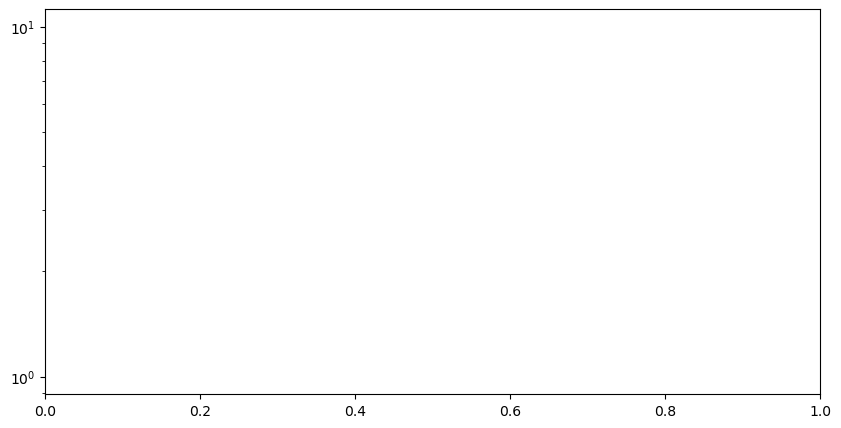

In [698]:
fig,ax= plt.subplots(figsize=(10,5))
counter_1 = 0
counter_2 = 0
counter_3 = 0

for i in range(0,48000,1):
    if system_name[i] == 'system_0':
        if states[i]=='healthy' and counter_1 <10 :            
            ax.semilogy(freq,PSDs[i],label='healthy',alpha=0.5,color='blue')
            counter_1 +=1
        elif states[i]=='anomalous' and counter_2 <50 and anomaly[i] == 0.05:
            ax.semilogy(freq,PSDs[i],label='anoumalous',alpha=0.5,color='red')
            counter_2 +=1

        elif states[i]=='anomalous' and counter_3 <50 and anomaly[i] == 0.11 :
            ax.semilogy(freq,PSDs[i],label='anoumalous',alpha=0.5,color='black')
            counter_3 +=1


In [ ]:
PSDs = np.log10(PSDs+EPS)


In [699]:
labels_name = {f'system_{i}' : i for i in range(0,20)}
def vec_translate(a, my_dict):    
    return np.vectorize(my_dict.__getitem__)(a)
system_name = vec_translate(system_name,labels_name)


In [700]:
print(f'amount of healthy samples {np.sum(states=="healthy")/len(states)} and amount of anomalous samples {np.sum(states=="anomalous")/len(states)}')


amount of healthy samples 0.46153846153846156 and amount of anomalous samples 0.5384615384615384


In [701]:
healthy_idx

array([28000, 28001, 28002, ..., 51997, 51998, 51999])

In [702]:
healthy_idx = np.where(states=='healthy')[0]
anomalous_idx = np.where(states=='anomalous')[0]

train_idx = np.random.choice(healthy_idx, size=min(healthy_idx.size,20*500), replace=False)
test_idx = np.setdiff1d(healthy_idx, train_idx)


In [703]:
train_idx

array([31501, 34421, 38623, ..., 51624, 46811, 36805])

In [704]:
PSDs_healthy = PSDs[healthy_idx]
system_name_healthy = system_name[healthy_idx]

PSDs_healthy_train = PSDs[train_idx]
system_name_healthy_train = system_name[train_idx]

PSDs_healthy_test = PSDs[test_idx]
system_name_healthy_test = system_name[test_idx]

In [705]:
PSDs_anomalous = PSDs[anomalous_idx]
system_name_anomalous = system_name[anomalous_idx]
anomaly_anomalous  = anomaly[anomalous_idx]

In [706]:
min_tr = PSDs_healthy_train.min()
max_tr = PSDs_healthy_train.max()
def normalize(data,min_value,max_value):
    return (data-min_value)/(max_value-min_value)



In [707]:
PSDs_healthy_train_nr = normalize(PSDs_healthy_train,min_tr,max_tr)
PSDs_healthy_test_nr = normalize(PSDs_healthy_test,min_tr,max_tr)
PSDs_anomalous_nr = normalize(PSDs_anomalous,min_tr,max_tr)

print(f'shapes :\n PSDs_healthy_train = {PSDs_healthy_train.shape} \n PSDs_healthy_test = {PSDs_healthy_test.shape} \n PSDs_anomalous = {PSDs_anomalous.shape}')

shapes :
 PSDs_healthy_train = (10000, 250) 
 PSDs_healthy_test = (14000, 250) 
 PSDs_anomalous = (28000, 250)


In [708]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(system_name_healthy_train.reshape(-1,1))
system_name_healthy_train_enc = enc.transform(system_name_healthy_train.reshape(-1,1)).toarray()


In [709]:
from PBSHM_mdof.models.classification.dense_nn import DenseSignalClassifier

model_ = DenseSignalClassifier(inputDim=(PSDs_healthy_train.shape[-1],), num_class=20,dense_layers=[128,64,32])
model=model_.build_model()

In [710]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 250)]             0         
                                                                 
 dense_signal_classifier_11   (None, 20)               43124     
 (DenseSignalClassifier)                                         
                                                                 
Total params: 43,124
Trainable params: 43,124
Non-trainable params: 0
_________________________________________________________________


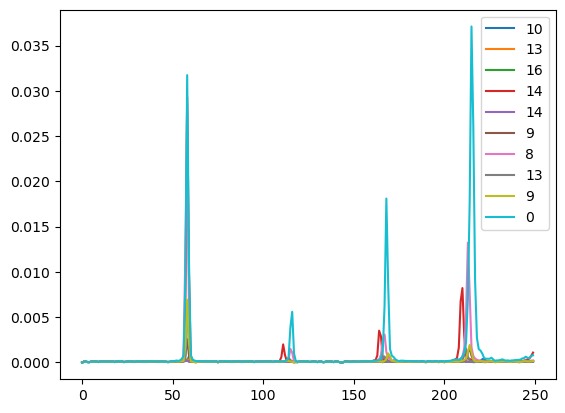

In [711]:
plt.plot(PSDs_healthy_train_nr[:10].T,label=system_name_healthy_train[:10])
plt.legend()

In [712]:
np.exp(PSDs).sum(axis=-1).mean()

/tmp/ipykernel_17476/1674689027.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(PSDs).sum(axis=-1).mean()
/home/yacine/anaconda3/envs/PBSHM_mdof_env/lib/python3.10/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


inf

In [713]:
hist=model.fit(PSDs_healthy_train_nr, system_name_healthy_train_enc, epochs=250, batch_size=64, validation_split=0.2)

Epoch 1/250
125/125 [==============================] - 1s 6ms/step - loss: 2.9278 - accuracy: 0.1112 - val_loss: 2.7301 - val_accuracy: 0.1915
Epoch 2/250
125/125 [==============================] - 1s 5ms/step - loss: 2.4364 - accuracy: 0.2319 - val_loss: 2.1652 - val_accuracy: 0.2875
Epoch 3/250
125/125 [==============================] - 1s 6ms/step - loss: 2.0280 - accuracy: 0.3507 - val_loss: 1.8803 - val_accuracy: 0.3835
Epoch 4/250
125/125 [==============================] - 1s 7ms/step - loss: 1.7424 - accuracy: 0.4791 - val_loss: 1.5922 - val_accuracy: 0.5000
Epoch 5/250
125/125 [==============================] - 1s 5ms/step - loss: 1.5052 - accuracy: 0.5732 - val_loss: 1.3643 - val_accuracy: 0.6505
Epoch 6/250
125/125 [==============================] - 1s 7ms/step - loss: 1.3080 - accuracy: 0.6590 - val_loss: 1.1966 - val_accuracy: 0.6750
Epoch 7/250
125/125 [==============================] - 1s 5ms/step - loss: 1.1559 - accuracy: 0.7051 - val_loss: 1.0535 - val_accuracy: 0.7425

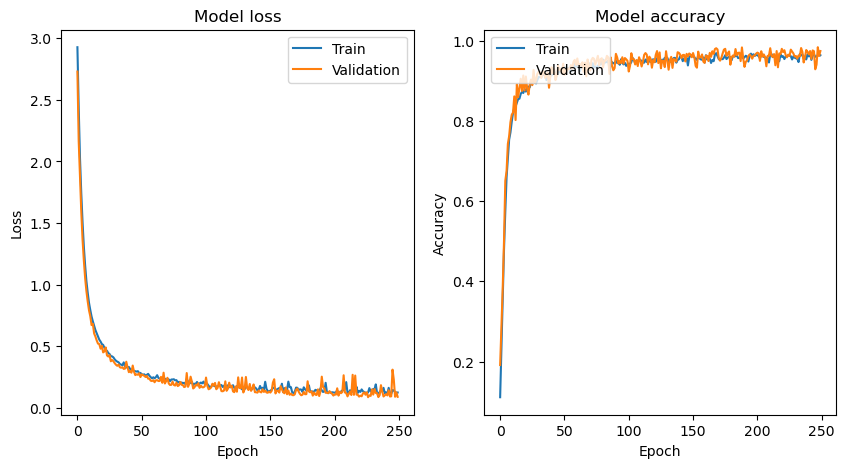

In [715]:
def plot_history(history, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper right')
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

plot_history(hist)
plt.show()

In [716]:
from sklearn.metrics import roc_auc_score
def compute_auc(data_normal,data_anoamly):

    confidence_anomaly_0 = data_normal['confidence']
    confidence_rest_of_anomalies = data_anoamly['confidence']

    # create the labels for the data
    # 1 for anomaly 0 and 0 for the rest of anomalies
    labels_anomaly_0 = [1] * len(confidence_anomaly_0)
    labels_rest_of_anomalies = [0] * len(confidence_rest_of_anomalies)

    # concatenate the data and labels
    confidence = np.concatenate((confidence_anomaly_0, confidence_rest_of_anomalies))
    labels = np.concatenate((labels_anomaly_0, labels_rest_of_anomalies))

    # compute the AUC
    auc = roc_auc_score(labels, confidence)
    return auc

def metric_auc(df_plot):
    df_result= pd.DataFrame({'anomaly':[],'auc':[]})
    df_plot_sys0 = df_plot[df_plot['system name']==0]

    train_healthy = df_plot_sys0[df_plot_sys0['test']==0]
    test_healthy = df_plot_sys0[(df_plot_sys0['test']==1)&(df_plot_sys0['anomaly']==0)]
    auc_tr_ts = compute_auc(train_healthy,test_healthy)
    df_result = df_result.append({'anomaly':0,'auc':auc_tr_ts},ignore_index=True)
    for anomaly_level in df_plot_sys0['anomaly'].unique():
        if anomaly_level>0:
            test_anomaly = df_plot_sys0[(df_plot_sys0['test']==1)&(df_plot_sys0['anomaly']==anomaly_level)]
            auc_tr_ts = compute_auc(test_healthy,test_anomaly)
            df_result = pd.concat([df_result, pd.DataFrame({'anomaly': [anomaly_level], 'auc': [auc_tr_ts]})], ignore_index=True)
    return df_result

def metric_plot(df_plot):
    fig,ax= plt.subplots(1,1,figsize=(10,5))
    df_sorted = df_plot[df_plot['system name']==0].sort_values(by=['test','anomaly']).reset_index(drop=True)    
    df_sorted[df_sorted['test']==0].plot(ax=ax,y='confidence',linestyle='',marker='dot',figsize=(10,5),alpha=1,color='green')
    df_sorted[df_sorted['test']==1].plot(ax=ax,y='confidence',linestyle='',marker='dot',figsize=(10,5),alpha=0.5,color='red')
    for i in range(0,8):
        if i == 0:
            ax.axvline(x=500+200*i,color='steelblue',linestyle='--',alpha=0.5)
            ax.text(500+200*i,0.3,'Test healthy ',rotation=90)
        else :
            ax.axvline(x=1000+200*i,color='steelblue',linestyle='--',alpha=0.5)
            ax.text(1000+200*i,0.3,'Anomaly '+str((i*2-1)/100),rotation=90)
    ax.set_xlabel('Index')
    ax.set_ylabel('Confidence')
    ax.set_title('Confidence of healthy and anomaly data')
    return fig 

    

In [717]:
PSDs_nr = normalize(PSDs,min_tr ,  max_tr)

In [718]:
score = model.predict(PSDs_nr)
confidence = score[np.ma.array(score, mask=system_name_enc).mask]
df_plot = pd.DataFrame({'system name':system_name,'confidence':confidence,'anomaly':anomaly})
df_plot['test'] = 1
df_plot.loc[train_idx,'test']=0 

1625/1625 [==============================] - 4s 2ms/step


   anomaly       auc
0     0.00  0.465812
1     0.01  0.626007
2     0.03  0.998634
3     0.05  0.999709
4     0.07  0.999935
5     0.09  0.999956
6     0.11  0.999985
7     0.13  0.999971


/tmp/ipykernel_17476/936853264.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({'anomaly':0,'auc':auc_tr_ts},ignore_index=True)


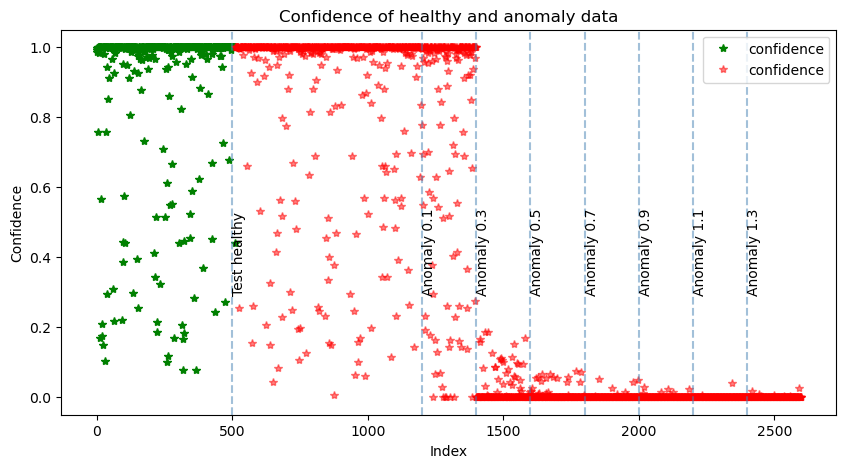

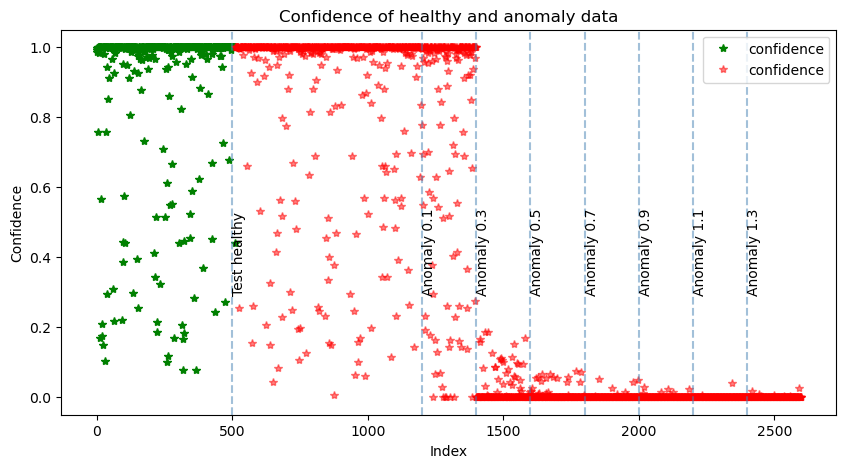

In [719]:
# SNR = 12 / fs = 50
print(metric_auc(df_plot))
metric_plot(df_plot)

In [721]:
20*0.37

7.4

   anomaly       auc
0     0.00  0.505016
1     0.01  0.786538
2     0.03  0.993104
3     0.05  0.998413
4     0.07  0.999803
5     0.09  0.999874
6     0.11  0.999993
7     0.13  0.999993


/tmp/ipykernel_17476/936853264.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({'anomaly':0,'auc':auc_tr_ts},ignore_index=True)


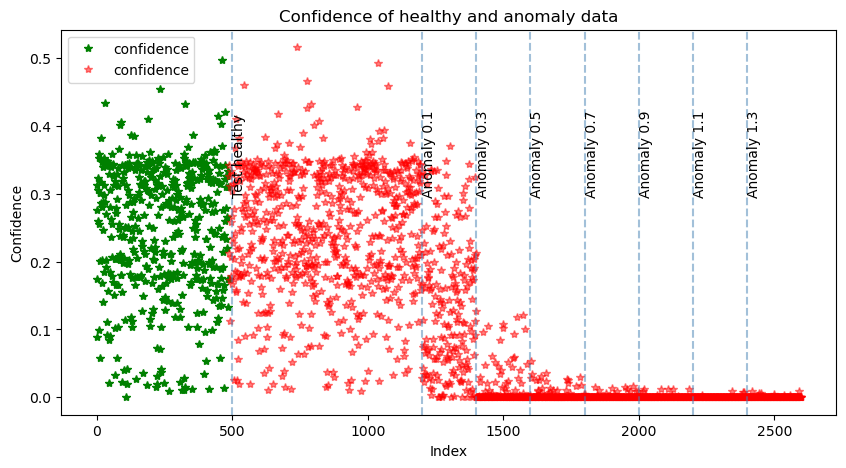

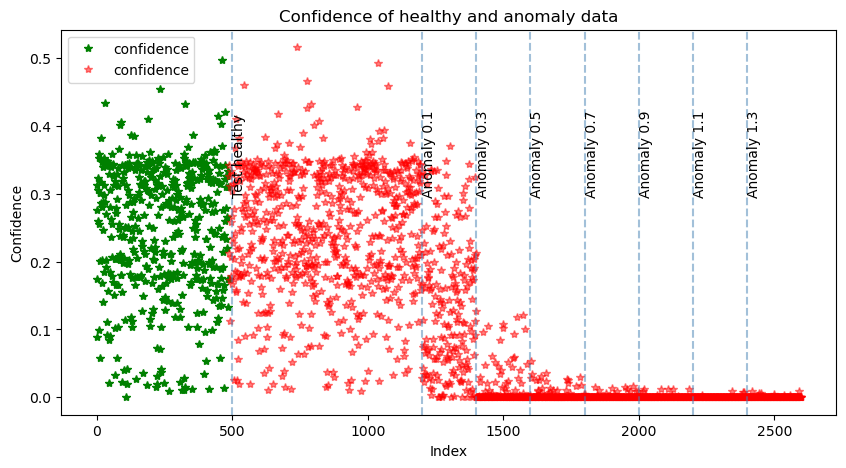

In [687]:
# noise_ fs = only the first pick 
print(metric_auc(df_plot))
metric_plot(df_plot)

In [ ]:
print(metric_auc(df_plot))
metric_plot(df_plot)

   anomaly       auc
0     0.00  0.528305
1     0.01  0.682443
2     0.03  0.996991
3     0.05  1.000000
4     0.07  1.000000
5     0.09  1.000000
6     0.11  1.000000
7     0.13  1.000000


/tmp/ipykernel_17476/936853264.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({'anomaly':0,'auc':auc_tr_ts},ignore_index=True)


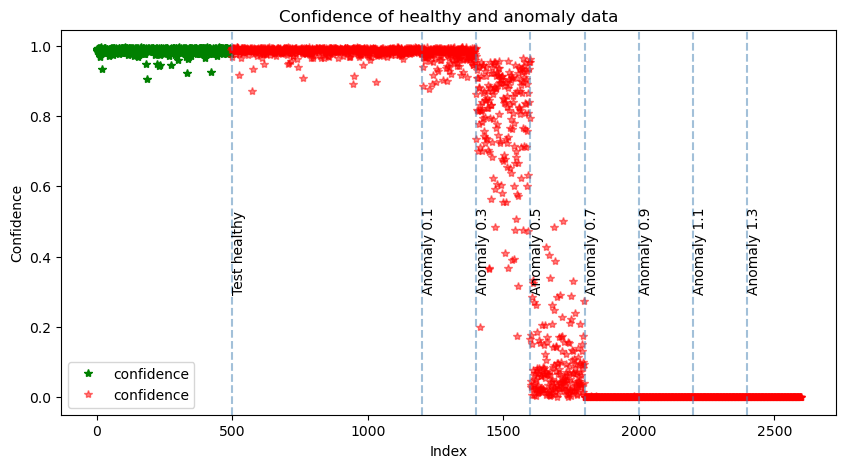

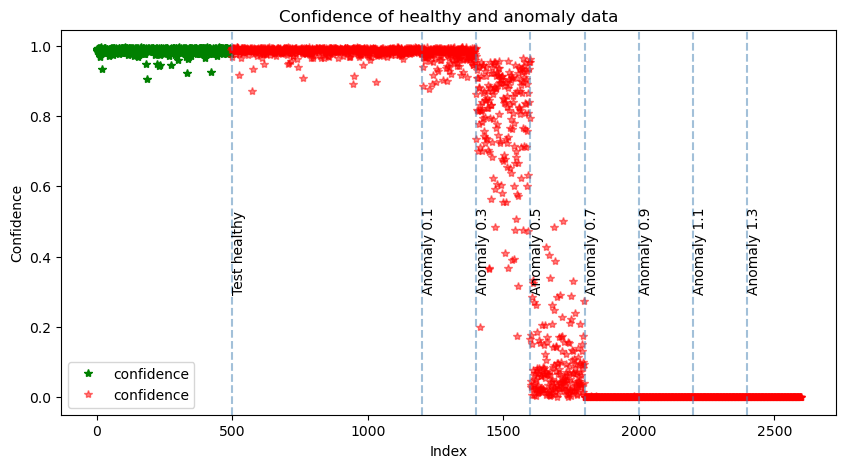

In [681]:
print(metric_auc(df_plot))
metric_plot(df_plot)

In [590]:
np.unique(np.argmax(score[np.where(system_name==0)],axis=-1))

array([ 0,  7, 11, 13])

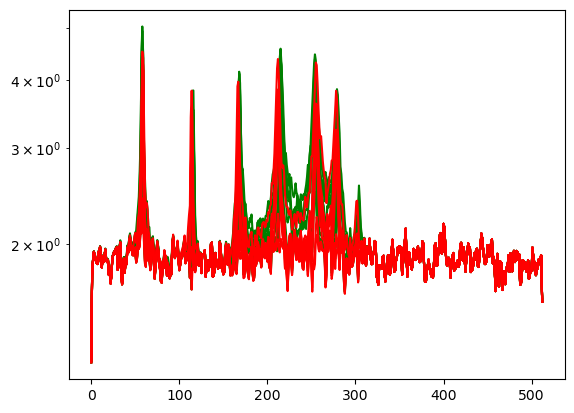

In [598]:
plt.plot(PSDs[np.where(system_name==0)][0:10].T,color='green')
plt.plot(PSDs[np.where(system_name==13)][0:10].T,color='red')
plt.yscale('log')


In [217]:
PSDs_nr=normalize(PSDs,min_tr,max_tr)

In [219]:
PSDs_nrscore = model.predict()

1625/1625 [==============================] - 9s 5ms/step


In [220]:
system_name_enc = enc.transform(system_name.reshape(-1,1)).toarray()

In [223]:
print(system_name_enc.shape)
print(score.shape)    summary.scalar('table', table_value, step=1)


(52000, 20)
(52000, 20)


In [236]:
system_name_enc

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [380]:
confidence = score[np.ma.array(score, mask=system_name_enc).mask]
df_plot = pd.DataFrame({'system name':system_name,'confidence':confidence,'anomaly':anomaly})
df_plot['test'] = 1
df_plot.loc[train_idx,'test']=0



Text(0.5, 1.0, 'Confidence of healthy and anomaly data')

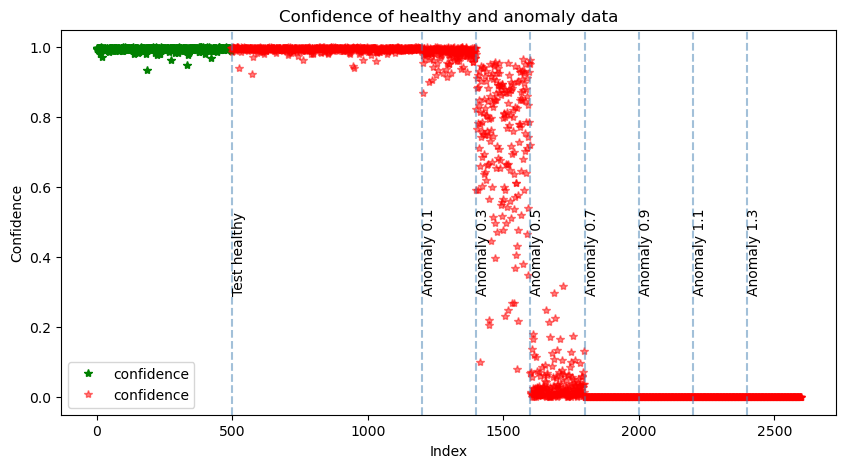

In [355]:
df_plot[df_plot['system name']==0].plot(x='anomaly',y='confidence',kind='violin',colormap='viridis')

ValueError: violin is not a valid plot kind

/tmp/ipykernel_17476/2974050766.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({'anomaly':0,'auc':auc_tr_ts},ignore_index=True)


In [338]:
df_result

,anomaly,auc
0,0.00,0.528879
1,0.01,0.763375
2,0.03,0.999495
3,0.05,1.000000
4,0.07,1.000000
5,0.09,1.000000
6,0.11,1.000000
7,0.13,1.000000


In [119]:
df_plot=pd.DataFrame({'confidence' : predict_0[:,0],
              'state' : state_0 })

<AxesSubplot: xlabel='confidence', ylabel='state'>

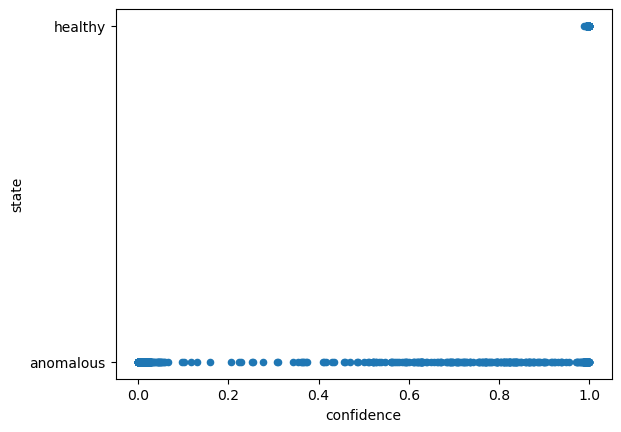

In [120]:
df_plot.plot(x='confidence',y='state',kind='scatter')


array([<AxesSubplot: title={'center': 'anomalous'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': 'healthy'}, ylabel='Frequency'>],
      dtype=object)

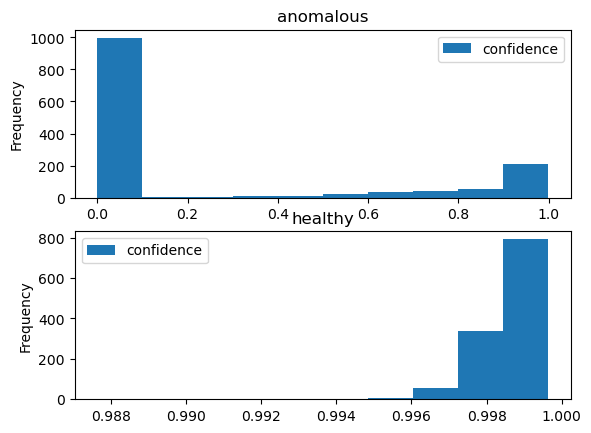

In [121]:
df_plot.plot.hist(by='state')


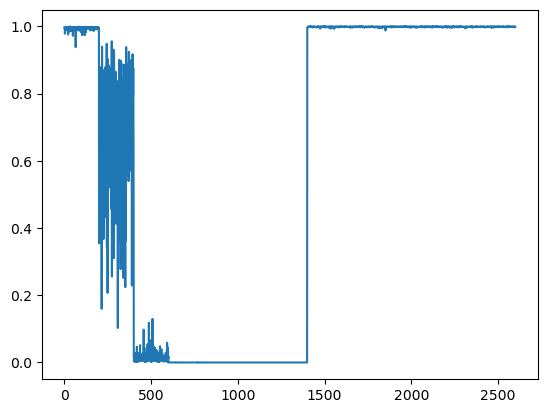

In [122]:
plt.plot(predict_0[:,0])

In [123]:
np.argmax(predict_0[1199:],axis=-1)

array([17, 17, 11, ...,  0,  0,  0])

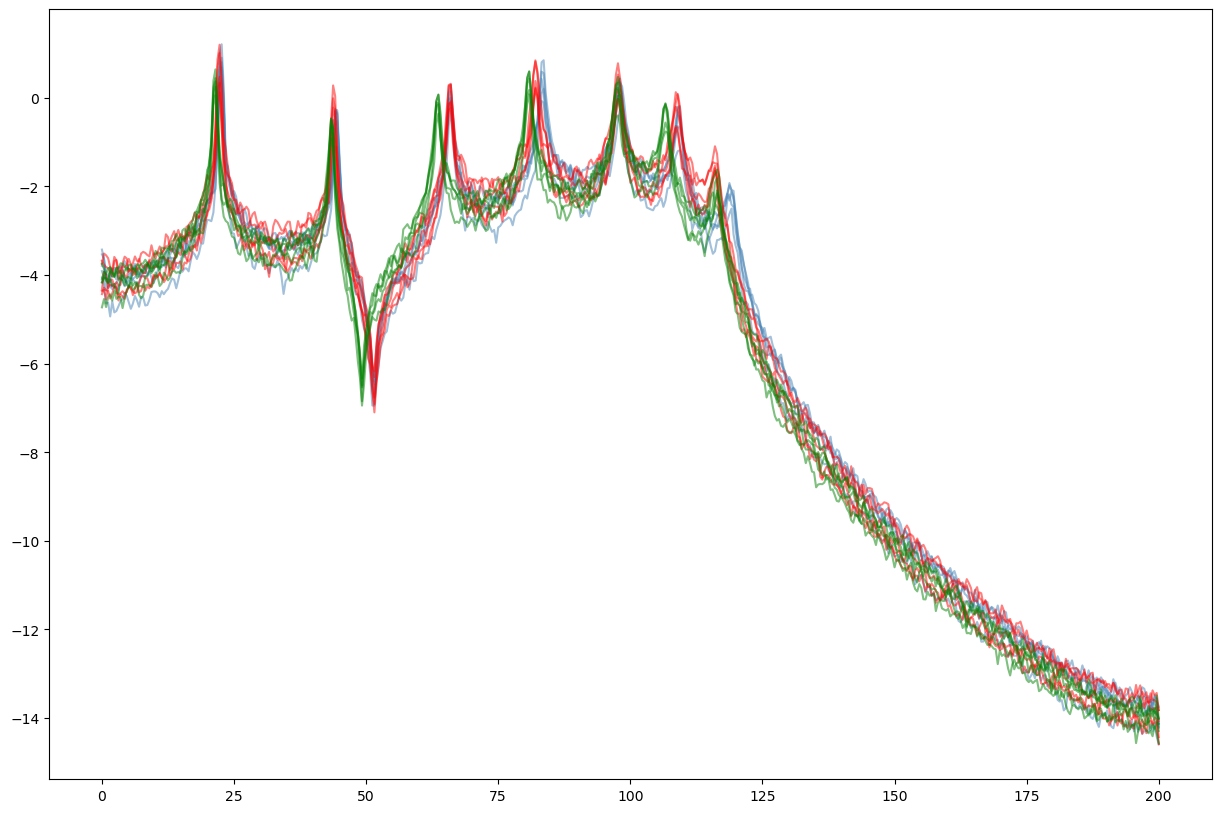

In [117]:
plt.figure(figsize=(15,10))
plt.plot(freq,PSDs[np.where((system_name==0) & (states=='healthy'))][0:5].T,color='steelblue',alpha=0.5)
plt.plot(freq,PSDs[np.where((system_name==0) & (states=='anomalous'))][0:5].T,color='red',alpha=0.5)
plt.plot(freq,PSDs[np.where((system_name==2) & (states=='anomalous'))][0:5].T,color='green',alpha=0.5)

In [ ]:
plt.plot(freq,PSDs[np.where(system_name==2)][0:10].T)